# Import Libraries

In [1]:
import os
import sqlite3 
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, SelectKBest

# Reading Data Files

In [2]:
db_file = './Data/score.db'

score = sqlite3.connect(database=db_file)
df = pd.read_sql_query(sql='select * from score', con=score, index_col='index')
df.head()

,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color
index,,,,,,,,,,,,,,,,,
0,0,Yes,Sports,Visual,ACN2BE,Female,No,69.0,14.0,2.0,16.0,10.0,91.0,22:00,6:00,private transport,yellow
1,2,No,Sports,Auditory,FGXIIZ,Female,No,47.0,4.0,19.0,16.0,7.0,94.0,22:30,6:30,private transport,green
2,0,Yes,None,Visual,B9AI9F,Male,No,85.0,14.0,2.0,15.0,8.0,92.0,22:30,6:30,private transport,white
3,1,No,Clubs,Auditory,FEVM1T,Female,Yes,64.0,2.0,20.0,15.0,18.0,NaN,21:00,5:00,public transport,yellow
4,0,No,Sports,Auditory,AXZN2E,Male,No,66.0,24.0,3.0,16.0,7.0,95.0,21:30,5:30,public transport,yellow


Findings

1) This is a regression problem as seen in the final_test column which contain a continuous quantity
2) The dataframe contain a mixture of numercial and categorical features
3) From a first glance, the student_id and bag_color column is redundant
4) The student_id is a random unique identifier assigned to each student and will have no impact on final_test score.
5) While the color of bag has no bearing on final test score
5) I will drop both these columns

In [3]:
df = df.drop(columns=['student_id', 'bag_color'])
df.head()

,number_of_siblings,direct_admission,CCA,learning_style,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport
index,,,,,,,,,,,,,,,
0,0,Yes,Sports,Visual,Female,No,69.0,14.0,2.0,16.0,10.0,91.0,22:00,6:00,private transport
1,2,No,Sports,Auditory,Female,No,47.0,4.0,19.0,16.0,7.0,94.0,22:30,6:30,private transport
2,0,Yes,None,Visual,Male,No,85.0,14.0,2.0,15.0,8.0,92.0,22:30,6:30,private transport
3,1,No,Clubs,Auditory,Female,Yes,64.0,2.0,20.0,15.0,18.0,NaN,21:00,5:00,public transport
4,0,No,Sports,Auditory,Male,No,66.0,24.0,3.0,16.0,7.0,95.0,21:30,5:30,public transport


# EDA
## Feature Selection for Numerical Columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15900 entries, 0 to 15899
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   number_of_siblings  15900 non-null  int64  
 1   direct_admission    15900 non-null  object 
 2   CCA                 15900 non-null  object 
 3   learning_style      15900 non-null  object 
 4   gender              15900 non-null  object 
 5   tuition             15900 non-null  object 
 6   final_test          15405 non-null  float64
 7   n_male              15900 non-null  float64
 8   n_female            15900 non-null  float64
 9   age                 15900 non-null  float64
 10  hours_per_week      15900 non-null  float64
 11  attendance_rate     15122 non-null  float64
 12  sleep_time          15900 non-null  object 
 13  wake_time           15900 non-null  object 
 14  mode_of_transport   15900 non-null  object 
dtypes: float64(6), int64(1), object(8)
memory usage: 1.9+

Findings

1) There are numerous missing values in the final_test and attendance_rate columns
2) This is displayed in the Non-Null values for both columns
3) In addition, there is a sleep_time and wake_time
4) I will feature engineer a sleep_duration column

In [5]:
df['sleep_time'] = pd.to_datetime(df['sleep_time'], format='%H:%M')
df['wake_time'] = pd.to_datetime(df['wake_time'], format='%H:%M')
df.head()

,number_of_siblings,direct_admission,CCA,learning_style,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport
index,,,,,,,,,,,,,,,
0,0,Yes,Sports,Visual,Female,No,69.0,14.0,2.0,16.0,10.0,91.0,1900-01-01 22:00:00,1900-01-01 06:00:00,private transport
1,2,No,Sports,Auditory,Female,No,47.0,4.0,19.0,16.0,7.0,94.0,1900-01-01 22:30:00,1900-01-01 06:30:00,private transport
2,0,Yes,None,Visual,Male,No,85.0,14.0,2.0,15.0,8.0,92.0,1900-01-01 22:30:00,1900-01-01 06:30:00,private transport
3,1,No,Clubs,Auditory,Female,Yes,64.0,2.0,20.0,15.0,18.0,NaN,1900-01-01 21:00:00,1900-01-01 05:00:00,public transport
4,0,No,Sports,Auditory,Male,No,66.0,24.0,3.0,16.0,7.0,95.0,1900-01-01 21:30:00,1900-01-01 05:30:00,public transport


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15900 entries, 0 to 15899
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   number_of_siblings  15900 non-null  int64         
 1   direct_admission    15900 non-null  object        
 2   CCA                 15900 non-null  object        
 3   learning_style      15900 non-null  object        
 4   gender              15900 non-null  object        
 5   tuition             15900 non-null  object        
 6   final_test          15405 non-null  float64       
 7   n_male              15900 non-null  float64       
 8   n_female            15900 non-null  float64       
 9   age                 15900 non-null  float64       
 10  hours_per_week      15900 non-null  float64       
 11  attendance_rate     15122 non-null  float64       
 12  sleep_time          15900 non-null  datetime64[ns]
 13  wake_time           15900 non-null  datetime64

Findings

1) The sleep_time and wake_time columns have been converted to datetime
2) However the date is imputed with 1900-01-01
3) I will add an additional day to wake_time to calculate the sleep duration when computing the difference
4) Once the sleep_duration is computed, the sleep_time and wake_time columns are redundant and will be dropped

In [7]:
df['wake_time'] = df['wake_time'] + pd.DateOffset(1)
df['sleep_duration'] = df['wake_time'] - df['sleep_time']
df['sleep_duration'] = df['sleep_duration'] / np.timedelta64(1, 'h')
df.head()

,number_of_siblings,direct_admission,CCA,learning_style,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,sleep_duration
index,,,,,,,,,,,,,,,,
0,0,Yes,Sports,Visual,Female,No,69.0,14.0,2.0,16.0,10.0,91.0,1900-01-01 22:00:00,1900-01-02 06:00:00,private transport,8.0
1,2,No,Sports,Auditory,Female,No,47.0,4.0,19.0,16.0,7.0,94.0,1900-01-01 22:30:00,1900-01-02 06:30:00,private transport,8.0
2,0,Yes,None,Visual,Male,No,85.0,14.0,2.0,15.0,8.0,92.0,1900-01-01 22:30:00,1900-01-02 06:30:00,private transport,8.0
3,1,No,Clubs,Auditory,Female,Yes,64.0,2.0,20.0,15.0,18.0,NaN,1900-01-01 21:00:00,1900-01-02 05:00:00,public transport,8.0
4,0,No,Sports,Auditory,Male,No,66.0,24.0,3.0,16.0,7.0,95.0,1900-01-01 21:30:00,1900-01-02 05:30:00,public transport,8.0


In [8]:
df = df.drop(columns=['sleep_time', 'wake_time'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15900 entries, 0 to 15899
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   number_of_siblings  15900 non-null  int64  
 1   direct_admission    15900 non-null  object 
 2   CCA                 15900 non-null  object 
 3   learning_style      15900 non-null  object 
 4   gender              15900 non-null  object 
 5   tuition             15900 non-null  object 
 6   final_test          15405 non-null  float64
 7   n_male              15900 non-null  float64
 8   n_female            15900 non-null  float64
 9   age                 15900 non-null  float64
 10  hours_per_week      15900 non-null  float64
 11  attendance_rate     15122 non-null  float64
 12  mode_of_transport   15900 non-null  object 
 13  sleep_duration      15900 non-null  float64
dtypes: float64(7), int64(1), object(6)
memory usage: 1.8+ MB


In [10]:
df['sleep_duration'].value_counts()

8.0     14621
7.0       527
29.0      233
28.0      152
30.0      145
31.0      127
6.0        95
Name: sleep_duration, dtype: int64

Findings

1) The sleep_duration is computed and converted to float
2) When I perform a value counts on the sleep_duration column, I notice values greater than 24 hours
3) This is not possible, the most probable reason is the individual had less than 6 hours of sleep
4) Therefore I will minus 24 hours from sleep durations greater than or equal to 24 hours
5) In addition sleep_time and wake_time columns are dropped

In [11]:
df['sleep_duration'] = df['sleep_duration'].apply(lambda x: (x - 24) if x >= 24 else x)

In [12]:
df['sleep_duration'].value_counts()

8.0    14621
7.0      654
6.0      240
5.0      233
4.0      152
Name: sleep_duration, dtype: int64

In [13]:
df.isna().sum()

number_of_siblings      0
direct_admission        0
CCA                     0
learning_style          0
gender                  0
tuition                 0
final_test            495
n_male                  0
n_female                0
age                     0
hours_per_week          0
attendance_rate       778
mode_of_transport       0
sleep_duration          0
dtype: int64

Findings

1) The sleep durations have been corrected for values greater than or equal to 24
2) There are 495 and 778 missing values in the final_test and attendance_rate columns respectively
3) Next up, I will normalize these values to find out the proportion of missing values in the dataframe

In [14]:
(df.isna().sum().sort_values(ascending=False) * 100)/ len(df)

attendance_rate       4.893082
final_test            3.113208
number_of_siblings    0.000000
direct_admission      0.000000
CCA                   0.000000
learning_style        0.000000
gender                0.000000
tuition               0.000000
n_male                0.000000
n_female              0.000000
age                   0.000000
hours_per_week        0.000000
mode_of_transport     0.000000
sleep_duration        0.000000
dtype: float64

## Findings

1) The missing values constitute 4.89% and 3.11% from attendance_rate and final_test, respectively.
3) I will drop the missing value in the target label, final_test.
4) For missing values in attendance rate, I will perform statistical test and EDA to deicide if the column is a feature to be used in modelling

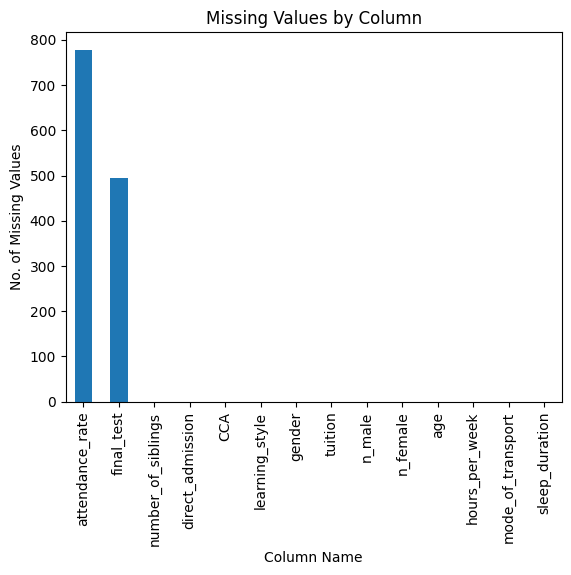

In [15]:
df.isna().sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Missing Values by Column')
plt.ylabel("No. of Missing Values")
plt.xlabel("Column Name");

## Findings

1) I will drop the missing values in the final_test column instead of imputing them
2) The reason is 2 fold, firstly, they constitute 3.11% of the dataframe which is about 495 rows, a small amount
3) Secondly, target label is not advised to be imputed as it controls how the machine learning alogorithm learns


In [16]:
df = df.dropna(axis=0, subset='final_test')

In [17]:
df.isna().sum().sort_values(ascending=False)

attendance_rate       757
number_of_siblings      0
direct_admission        0
CCA                     0
learning_style          0
gender                  0
tuition                 0
final_test              0
n_male                  0
n_female                0
age                     0
hours_per_week          0
mode_of_transport       0
sleep_duration          0
dtype: int64

In [18]:
df.head()

,number_of_siblings,direct_admission,CCA,learning_style,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,mode_of_transport,sleep_duration
index,,,,,,,,,,,,,,
0,0,Yes,Sports,Visual,Female,No,69.0,14.0,2.0,16.0,10.0,91.0,private transport,8.0
1,2,No,Sports,Auditory,Female,No,47.0,4.0,19.0,16.0,7.0,94.0,private transport,8.0
2,0,Yes,None,Visual,Male,No,85.0,14.0,2.0,15.0,8.0,92.0,private transport,8.0
3,1,No,Clubs,Auditory,Female,Yes,64.0,2.0,20.0,15.0,18.0,NaN,public transport,8.0
4,0,No,Sports,Auditory,Male,No,66.0,24.0,3.0,16.0,7.0,95.0,public transport,8.0


Findings

1. The missing values in the final_test column have been dropped
2. Now to address the missing values in the attendance_rate column
3. I will determine if the column displays a high correlation with the target label
4. But before determining the feature selection and correlation, I will perform train test split
5. Calculating correlation and selecting features before perform train test split will result in data leakage

In [19]:
X = df.drop(columns='final_test')
y = df['final_test']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [20]:
temp_df = pd.concat(objs=[X_train, y_train], axis=1)
temp_df.head()

,number_of_siblings,direct_admission,CCA,learning_style,gender,tuition,n_male,n_female,age,hours_per_week,attendance_rate,mode_of_transport,sleep_duration,final_test
index,,,,,,,,,,,,,,
7297,2,No,Clubs,Auditory,Male,Yes,21.0,0.0,16.0,18.0,95.0,public transport,8.0,71.0
327,1,No,Clubs,Auditory,Female,Yes,4.0,20.0,16.0,5.0,93.0,private transport,8.0,64.0
1372,2,Yes,Sports,Visual,Male,No,10.0,5.0,15.0,8.0,90.0,public transport,7.0,68.0
4603,2,No,Sports,Auditory,Female,Yes,3.0,19.0,5.0,4.0,53.0,private transport,4.0,42.0
8042,1,No,Arts,Visual,Female,No,13.0,12.0,16.0,5.0,97.0,private transport,8.0,47.0


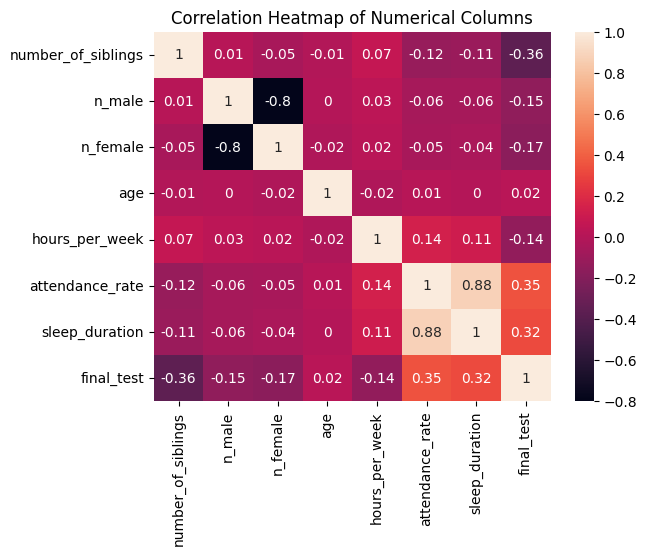

In [21]:
sns.heatmap(data=round(temp_df.corr(numeric_only=True),2), annot=True)
plt.title('Correlation Heatmap of Numerical Columns');

Findings

1. The attendance_rate displays a relatively greater positive correlation compared to the other features
2. I will impute the attendance rate with either mean, median or mode
3. I will look into more statistics of attendance_rate
4. In addition, the number_of_siblings depict a relatively low correlation therefore I will keep the column to train the model.
5. I will drop n_male, n_female, age and hours_per_week due to the relatively low absolute low correlation.

In [22]:
temp_df.describe(percentiles=[0.25,0.5,0.75])

,number_of_siblings,n_male,n_female,age,hours_per_week,attendance_rate,sleep_duration,final_test
count,10321.000000,10321.000000,10321.000000,10321.000000,10321.000000,9824.000000,10321.000000,10321.000000
mean,0.886445,13.927042,8.869489,15.220618,10.339599,93.296824,7.849433,67.130317
std,0.752831,6.549499,6.673368,1.733299,4.482424,7.904309,0.598611,13.929410
min,0.000000,0.000000,0.000000,-5.000000,0.000000,40.000000,4.000000,32.000000
25%,0.000000,10.000000,3.000000,15.000000,7.000000,92.000000,8.000000,56.000000
50%,1.000000,14.000000,8.000000,15.000000,9.000000,95.000000,8.000000,68.000000
75%,1.000000,18.000000,13.000000,16.000000,14.000000,97.000000,8.000000,77.000000
max,2.000000,31.000000,31.000000,16.000000,20.000000,100.000000,8.000000,100.000000


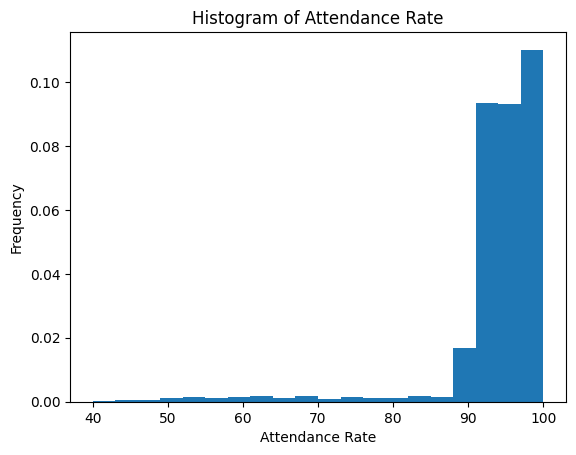

In [23]:
plt.hist(x=temp_df['attendance_rate'], bins=20, density=True)
plt.title('Histogram of Attendance Rate')
plt.xlabel('Attendance Rate')
plt.ylabel('Frequency');

# Findings

1. For attendance_rate, the mean is slightly lower than the 50th percentile or in another word, median
2. This mean thats the distribution for attendance_rate is skewed to the left
3. I will fill missing values in the attendance_rate column with the median due to the skewedness.

In [24]:
temp_df.head()

,number_of_siblings,direct_admission,CCA,learning_style,gender,tuition,n_male,n_female,age,hours_per_week,attendance_rate,mode_of_transport,sleep_duration,final_test
index,,,,,,,,,,,,,,
7297,2,No,Clubs,Auditory,Male,Yes,21.0,0.0,16.0,18.0,95.0,public transport,8.0,71.0
327,1,No,Clubs,Auditory,Female,Yes,4.0,20.0,16.0,5.0,93.0,private transport,8.0,64.0
1372,2,Yes,Sports,Visual,Male,No,10.0,5.0,15.0,8.0,90.0,public transport,7.0,68.0
4603,2,No,Sports,Auditory,Female,Yes,3.0,19.0,5.0,4.0,53.0,private transport,4.0,42.0
8042,1,No,Arts,Visual,Female,No,13.0,12.0,16.0,5.0,97.0,private transport,8.0,47.0


In [25]:
attendance_rate_median = temp_df['attendance_rate'].median(skipna=True, numeric_only=True)
attendance_rate_median

95.0

In [26]:
df.head()

,number_of_siblings,direct_admission,CCA,learning_style,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,mode_of_transport,sleep_duration
index,,,,,,,,,,,,,,
0,0,Yes,Sports,Visual,Female,No,69.0,14.0,2.0,16.0,10.0,91.0,private transport,8.0
1,2,No,Sports,Auditory,Female,No,47.0,4.0,19.0,16.0,7.0,94.0,private transport,8.0
2,0,Yes,None,Visual,Male,No,85.0,14.0,2.0,15.0,8.0,92.0,private transport,8.0
3,1,No,Clubs,Auditory,Female,Yes,64.0,2.0,20.0,15.0,18.0,NaN,public transport,8.0
4,0,No,Sports,Auditory,Male,No,66.0,24.0,3.0,16.0,7.0,95.0,public transport,8.0


In [27]:
df['attendance_rate'] = df['attendance_rate'].fillna(value=attendance_rate_median)

In [28]:
df.isna().sum().sort_values(ascending=False)

number_of_siblings    0
direct_admission      0
CCA                   0
learning_style        0
gender                0
tuition               0
final_test            0
n_male                0
n_female              0
age                   0
hours_per_week        0
attendance_rate       0
mode_of_transport     0
sleep_duration        0
dtype: int64

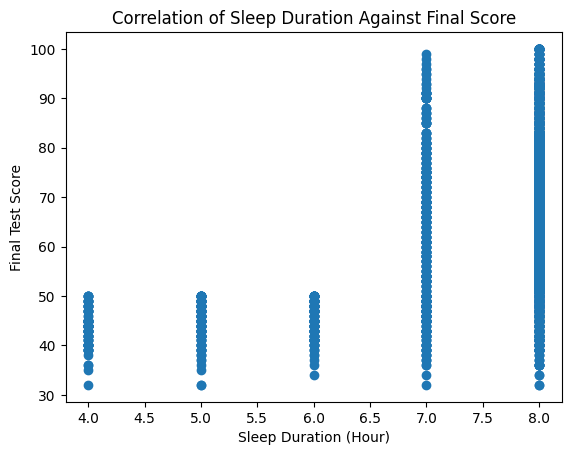

In [29]:
plt.scatter(x = temp_df['sleep_duration'], y = temp_df['final_test'])
plt.title('Correlation of Sleep Duration Against Final Score')
plt.xlabel('Sleep Duration (Hour)')
plt.ylabel('Final Test Score');

Findings

1. There are no more missing values in the dataframe
2. In addition, the sleep_duration corresponds to a higher final_test score from the scatter plot, I will keep this feature for the alogrithim to learn
2. I will proceed to drop the columns, age, n_male, n_female and hours_per_week due to the relatively low absolute low correlation.

In [30]:
df = df.drop(columns=['n_male', 'n_female', 'age', 'hours_per_week'])
df.head()

,number_of_siblings,direct_admission,CCA,learning_style,gender,tuition,final_test,attendance_rate,mode_of_transport,sleep_duration
index,,,,,,,,,,
0,0,Yes,Sports,Visual,Female,No,69.0,91.0,private transport,8.0
1,2,No,Sports,Auditory,Female,No,47.0,94.0,private transport,8.0
2,0,Yes,None,Visual,Male,No,85.0,92.0,private transport,8.0
3,1,No,Clubs,Auditory,Female,Yes,64.0,95.0,public transport,8.0
4,0,No,Sports,Auditory,Male,No,66.0,95.0,public transport,8.0


In [31]:
temp_df = temp_df.drop(columns=['n_male', 'n_female', 'age', 'hours_per_week'])
temp_df.head()

,number_of_siblings,direct_admission,CCA,learning_style,gender,tuition,attendance_rate,mode_of_transport,sleep_duration,final_test
index,,,,,,,,,,
7297,2,No,Clubs,Auditory,Male,Yes,95.0,public transport,8.0,71.0
327,1,No,Clubs,Auditory,Female,Yes,93.0,private transport,8.0,64.0
1372,2,Yes,Sports,Visual,Male,No,90.0,public transport,7.0,68.0
4603,2,No,Sports,Auditory,Female,Yes,53.0,private transport,4.0,42.0
8042,1,No,Arts,Visual,Female,No,97.0,private transport,8.0,47.0


## Feature Selection for Categorical Columns

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15405 entries, 0 to 15899
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   number_of_siblings  15405 non-null  int64  
 1   direct_admission    15405 non-null  object 
 2   CCA                 15405 non-null  object 
 3   learning_style      15405 non-null  object 
 4   gender              15405 non-null  object 
 5   tuition             15405 non-null  object 
 6   final_test          15405 non-null  float64
 7   attendance_rate     15405 non-null  float64
 8   mode_of_transport   15405 non-null  object 
 9   sleep_duration      15405 non-null  float64
dtypes: float64(3), int64(1), object(6)
memory usage: 1.3+ MB


In [33]:
temp_df.head()

,number_of_siblings,direct_admission,CCA,learning_style,gender,tuition,attendance_rate,mode_of_transport,sleep_duration,final_test
index,,,,,,,,,,
7297,2,No,Clubs,Auditory,Male,Yes,95.0,public transport,8.0,71.0
327,1,No,Clubs,Auditory,Female,Yes,93.0,private transport,8.0,64.0
1372,2,Yes,Sports,Visual,Male,No,90.0,public transport,7.0,68.0
4603,2,No,Sports,Auditory,Female,Yes,53.0,private transport,4.0,42.0
8042,1,No,Arts,Visual,Female,No,97.0,private transport,8.0,47.0


In [34]:
pd.get_dummies(temp_df).head()

,number_of_siblings,attendance_rate,sleep_duration,final_test,direct_admission_No,direct_admission_Yes,CCA_ARTS,CCA_Arts,CCA_CLUBS,CCA_Clubs,...,learning_style_Visual,gender_Female,gender_Male,tuition_N,tuition_No,tuition_Y,tuition_Yes,mode_of_transport_private transport,mode_of_transport_public transport,mode_of_transport_walk
index,,,,,,,,,,,,,,,,,,,,,
7297,2,95.0,8.0,71.0,1,0,0,0,0,1,...,0,0,1,0,0,0,1,0,1,0
327,1,93.0,8.0,64.0,1,0,0,0,0,1,...,0,1,0,0,0,0,1,1,0,0
1372,2,90.0,7.0,68.0,0,1,0,0,0,0,...,1,0,1,0,1,0,0,0,1,0
4603,2,53.0,4.0,42.0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
8042,1,97.0,8.0,47.0,1,0,0,1,0,0,...,1,1,0,0,1,0,0,1,0,0


In [35]:
temp_df['tuition'].value_counts()

Yes    5611
No     4322
Y       212
N       176
Name: tuition, dtype: int64

Findings

1. For the tuition column, there are 4 values, Yes, No, Y, N
2. I will change Yes and No to Y and N respectively
3. I will set drop_first as True when pd.get_dummies to decrease the number of columns

In [36]:
df['tuition'] = df['tuition'].str.replace(pat='Yes', repl='Y')
df['tuition'] = df['tuition'].str.replace(pat='No', repl='N')

temp_df['tuition'] = temp_df['tuition'].str.replace(pat='Yes', repl='Y')
temp_df['tuition'] = temp_df['tuition'].str.replace(pat='No', repl='N')

In [37]:
df['tuition'].value_counts()

Y    8716
N    6689
Name: tuition, dtype: int64

In [38]:
temp_df['tuition'].value_counts()

Y    5823
N    4498
Name: tuition, dtype: int64

In [39]:
temp_df.head()

,number_of_siblings,direct_admission,CCA,learning_style,gender,tuition,attendance_rate,mode_of_transport,sleep_duration,final_test
index,,,,,,,,,,
7297,2,No,Clubs,Auditory,Male,Y,95.0,public transport,8.0,71.0
327,1,No,Clubs,Auditory,Female,Y,93.0,private transport,8.0,64.0
1372,2,Yes,Sports,Visual,Male,N,90.0,public transport,7.0,68.0
4603,2,No,Sports,Auditory,Female,Y,53.0,private transport,4.0,42.0
8042,1,No,Arts,Visual,Female,N,97.0,private transport,8.0,47.0


In [40]:
pd.get_dummies(temp_df).head()

,number_of_siblings,attendance_rate,sleep_duration,final_test,direct_admission_No,direct_admission_Yes,CCA_ARTS,CCA_Arts,CCA_CLUBS,CCA_Clubs,...,CCA_Sports,learning_style_Auditory,learning_style_Visual,gender_Female,gender_Male,tuition_N,tuition_Y,mode_of_transport_private transport,mode_of_transport_public transport,mode_of_transport_walk
index,,,,,,,,,,,,,,,,,,,,,
7297,2,95.0,8.0,71.0,1,0,0,0,0,1,...,0,1,0,0,1,0,1,0,1,0
327,1,93.0,8.0,64.0,1,0,0,0,0,1,...,0,1,0,1,0,0,1,1,0,0
1372,2,90.0,7.0,68.0,0,1,0,0,0,0,...,1,0,1,0,1,1,0,0,1,0
4603,2,53.0,4.0,42.0,1,0,0,0,0,0,...,1,1,0,1,0,0,1,1,0,0
8042,1,97.0,8.0,47.0,1,0,0,1,0,0,...,0,0,1,1,0,1,0,1,0,0


In [41]:
temp_df = pd.get_dummies(temp_df, drop_first=True)
df = pd.get_dummies(df, drop_first=True)

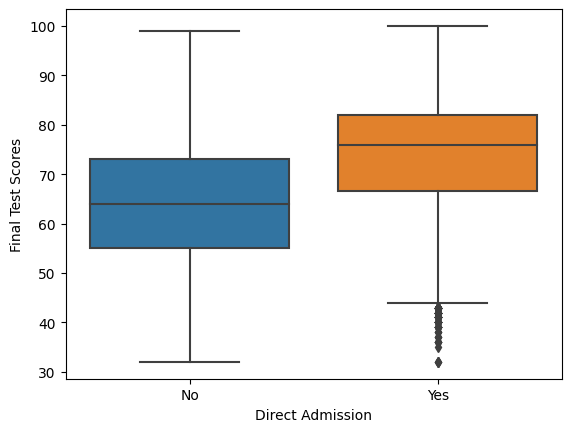

In [42]:
ax = sns.boxplot(data=temp_df, x='direct_admission_Yes', y='final_test')
ax.set_xticks([0,1])
ax.set_xticklabels(['No', 'Yes'])
ax.set(xlabel='Direct Admission', ylabel='Final Test Scores');

Findings

1. There is a marked difference in final test scores between students who entered the school thru direct admission and those not.
2. I will keep this column
3. For the remaining features, I will perform an ANOVA test

In [43]:
temp_df.head()

,number_of_siblings,attendance_rate,sleep_duration,final_test,direct_admission_Yes,CCA_Arts,CCA_CLUBS,CCA_Clubs,CCA_NONE,CCA_None,CCA_SPORTS,CCA_Sports,learning_style_Visual,gender_Male,tuition_Y,mode_of_transport_public transport,mode_of_transport_walk
index,,,,,,,,,,,,,,,,,
7297,2,95.0,8.0,71.0,0,0,0,1,0,0,0,0,0,1,1,1,0
327,1,93.0,8.0,64.0,0,0,0,1,0,0,0,0,0,0,1,0,0
1372,2,90.0,7.0,68.0,1,0,0,0,0,0,0,1,1,1,0,1,0
4603,2,53.0,4.0,42.0,0,0,0,0,0,0,0,1,0,0,1,0,0
8042,1,97.0,8.0,47.0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [44]:
temp_df = temp_df.drop(columns=['number_of_siblings', 'attendance_rate', 'sleep_duration', 'direct_admission_Yes'])
temp_df.head()

,final_test,CCA_Arts,CCA_CLUBS,CCA_Clubs,CCA_NONE,CCA_None,CCA_SPORTS,CCA_Sports,learning_style_Visual,gender_Male,tuition_Y,mode_of_transport_public transport,mode_of_transport_walk
index,,,,,,,,,,,,,
7297,71.0,0,0,1,0,0,0,0,0,1,1,1,0
327,64.0,0,0,1,0,0,0,0,0,0,1,0,0
1372,68.0,0,0,0,0,0,0,1,1,1,0,1,0
4603,42.0,0,0,0,0,0,0,1,0,0,1,0,0
8042,47.0,1,0,0,0,0,0,0,1,0,0,0,0


In [45]:
X = temp_df.drop(columns='final_test')
y = temp_df['final_test']

In [46]:
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(X=X, y=y)

fs_scores = pd.DataFrame(data=fs.scores_, index=X.columns, columns=['Value']).sort_values(by='Value', ascending=False)
fs_scores

,Value
CCA_None,39.316875
learning_style_Visual,20.525690
tuition_Y,18.359638
gender_Male,7.495528
CCA_Clubs,4.427030
CCA_Sports,4.402168
CCA_Arts,4.340394
CCA_NONE,1.511756
mode_of_transport_walk,1.224007
CCA_SPORTS,1.107256


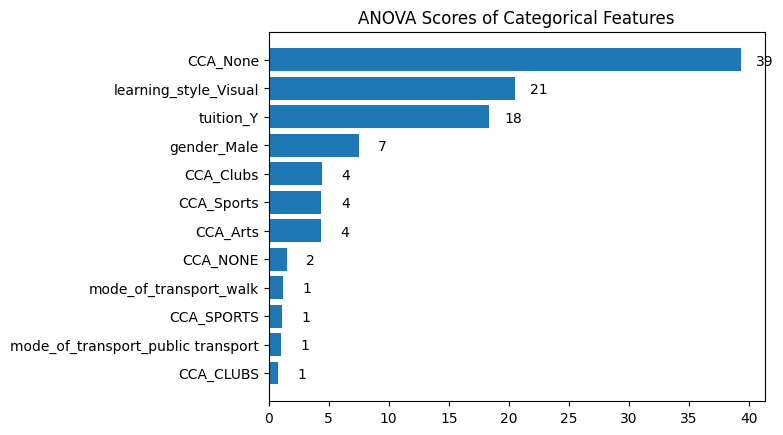

In [47]:
ax = plt.barh(y=fs_scores.index, width=fs_scores['Value'])
plt.gca().invert_yaxis()
plt.title('ANOVA Scores of Categorical Features')

for p in ax.patches:
    width = p.get_width()
    plt.text(2+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.0f}'.format(width),
             ha='center', va='center')

Findings

1. I will keep features with ANOVA score 10 or greater
2. Therefore learning_style_Visual, CCA_None and tuition_Y will be kept
3. The other features will be dropped

In [48]:
df = df[['number_of_siblings', 'attendance_rate', 'sleep_duration', 'direct_admission_Yes', 'learning_style_Visual', 'CCA_None', 'tuition_Y', 'final_test']]
df.head()

,number_of_siblings,attendance_rate,sleep_duration,direct_admission_Yes,learning_style_Visual,CCA_None,tuition_Y,final_test
index,,,,,,,,
0,0,91.0,8.0,1,1,0,0,69.0
1,2,94.0,8.0,0,0,0,0,47.0
2,0,92.0,8.0,1,1,1,0,85.0
3,1,95.0,8.0,0,0,0,1,64.0
4,0,95.0,8.0,0,0,0,0,66.0


Summary

1. This will be the dataframe I will model on
2. However before modelling there are a few more preprocessing steps, normalization and train test split
3. I will save this dataframe as a csv file

In [49]:
df.to_csv('./Data/df_cleaned.csv')